딥러닝 연습장 20210607
--

딥러닝 복습

In [1]:
import pandas as pd
import tensorflow as tf

퍼셉트론 복습

신호전달을 활성함수로 처리한다.

XOR 문제를 선형함수가 아닌 비선형함수로 처리

hidden 노드에서는 y-yhat 에서 y값을 알 수 없다.

오류 역전파는 다항함수일 때 체인룰을 사용한다.

가령 ∂z/∂x = ∂z/∂y*∂y/∂x 가 되는 것이다. (d는 미분을 의미하므로, 여기서는 편미분 기호로 반드시 써야함.)

CNN 복습

- CNN은 OpenCV로 전처리가 중요하다. 영상쪽은 C가 필수!


- MNIST

Batch Normalization

Internal Covariate Shift : 네트워크의 학습 도중에 파라미터의 변화로 인한 네트워크 Activation(출력)들의 분포 변화

기존의 여러 연구 결과들은 입력값들이 Whitening된다(zero Mean & Unit Variance)면, 뉴럴넷이 훨씬 빠르게 수렴할 것이라고 말하고 있다.

이러한 방법은 Gradient Descent Step의 효과를 줄이는 결과를 초래

또한 Backpropagation 방법도 복잡함
Mini batch 단위로 다음을 수행.
$BN(x;\gamma,\beta)=\beta+\gamma\dfrac{x-E(x)}
{\sqrt{Var(x)+\epsilon}}$

BN은 학습 속도를 향상시켜주고 Gradient Vanishing 문제도 완화시켜줌.

자세한 내용(https://hcnoh.github.io/2018-11-27-batch-normalization)

Keras 보스턴 집값 예측 활용
--

https://wdprogrammer.tistory.com/30

In [ ]:
boston=tf.keras.datasets.boston_housing.load_data(path="boston_housing.npz", test_split=0.2, seed=113)

In [ ]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

데이터 전처리

In [ ]:
mean=train_data.mean(axis=0)
train_data -= mean
std=train_data.std(axis=0)
train_data /= std 

test_data -= mean
test_data /=  std

모델 구성

In [ ]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

모델 학습 및 검증

In [ ]:
import numpy as np
k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
all_mae_histories = []
for i in  range(k):
    print("processing fold #", i)
    # 검증 데이터 분리
    val_data  = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

    # 훈련 데이터 분리
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    # 모델 학습
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    
    model.compile('sgd', metrics=[tf.keras.metrics.MeanAbsoluteError()])
    mae_history = history.history['mae']
    #mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

MAE 그래프 그리기

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, 'r', label='aver_mae')
plt.title('MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [ ]:
average_mae_history[:5]

폐암 수술환자의 생존율 예측하기 실습
--
https://twinw.tistory.com/248


- activation: 다음 층으로 어떻게 값을 넘길지 결정하는 부분으로, relu, sigmoid 함수 등등이 있다.

- loss: 한 번 신경망이 실행될 때마다 오차 값을 추적하는 함수

- optimizer: 오차를 어떻게 줄여 나갈지 정하는 함수

In [ ]:
from google.colab import files
files.upload()

In [ ]:
import pandas as pd
df_cancer=pd.read_csv('ThoraricSurgery.csv')
cancer=numpy.loadtxt('ThoraricSurgery.csv', delimiter=",") # pd.read_csv가 아닌 numpy.loadtxt를 활용

In [ ]:
df_cancer=pd.DataFrame(df_cancer)
df_cancer # 18개의 속성을 가지고 있는 것을 알 수 있다.

In [ ]:
cancer

In [ ]:
from keras.models import Sequential # 딥러닝을 여행으로 비유한다면, 케라스는 비행기의 이륙 및 정확한 지점까지의 도착을 책잊미는 파일럿
from keras.layers import Dense

import numpy
import tensorflow as tf # 딥러닝을 여행으로 비유한다면, 텐서플로는 목적지까지 빠르게 이동시켜주는 비행기

seed=0
numpy.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
X=cancer[:, 0:17]
X

In [ ]:
Y=cancer[:,17] # target
Y

In [ ]:
# 딥러닝 모델 구성

model=Sequential() #모델 불러오기
model.add(Dense(30, input_dim=17, activation='relu')) # 모델의 2층 옵션
model.add(Dense(1, activation='sigmoid')) # 모델의 1층 옵션

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy']) #모델을 실행시키기 위한 조건
model.fit(X,Y, epochs=30, batch_size=10) # 모델 실행

In [ ]:
# 결과 출력하기
print("\n Accuracy: %.4f" %(model.evaluate(X,Y)[1])) # 딥러닝 모델이 어느 정도 정확하게 예측하는지를 점검

피마 인디언 당뇨병 여부 측정 실습
--

In [ ]:
from google.colab import files
files.upload()

In [ ]:
diabetes=pd.read_csv('diabetes.csv')

In [ ]:
diavetes

In [ ]:
import seaborn as sns

sns.heatmap(diabetes.corr(), cmap='Greens', annot=True)

In [ ]:
diabetes.columns

In [ ]:
Pre=[float(x) for x in diabetes['Pregnancies']]

In [ ]:
diabetes['Pregnancies']=Pre

In [ ]:
diabetes['Pregnancies']

In [ ]:
Glu=[float(x) for x in diabetes['Glucose']]
diabetes['Glucose']=Glu

BP=[float(x) for x in diabetes['BloodPressure']]
diabetes['BloodPressure']=BP


ST=[float(x) for x in diabetes['SkinThickness']]
diabetes['SkinThickness']=ST

IS=[float(x) for x in diabetes['Insulin']]
diabetes['Insulin']=IS


Age=[float(x) for x in diabetes['Age']]
diabetes['Age']=Age

In [ ]:
Outcome=[float(x) for x in diabetes['Outcome']]
diabetes['Outcome']=Outcome

In [ ]:
diabetes.head()

In [ ]:
diabetes.info()

In [ ]:
X=diabetes.drop(['Outcome'], axis=1)
Y=diabetes['Outcome']

In [ ]:
seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
model=Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X,Y, epochs=200, batch_size=10)

In [ ]:
print("\n Accuracy: %.4f" %(model.evaluate(X,Y)[1]))

IRIS 데이터
--

In [ ]:
from sklearn.datasets import load_iris

iris=load_iris()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [ ]:
df=pd.DataFrame(data=iris.data, columns=iris.feature_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [ ]:
df2=pd.DataFrame(iris.target, columns=['species'])

In [ ]:
df2

,species
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


In [ ]:
data=pd.concat([df, df2], axis=1)
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


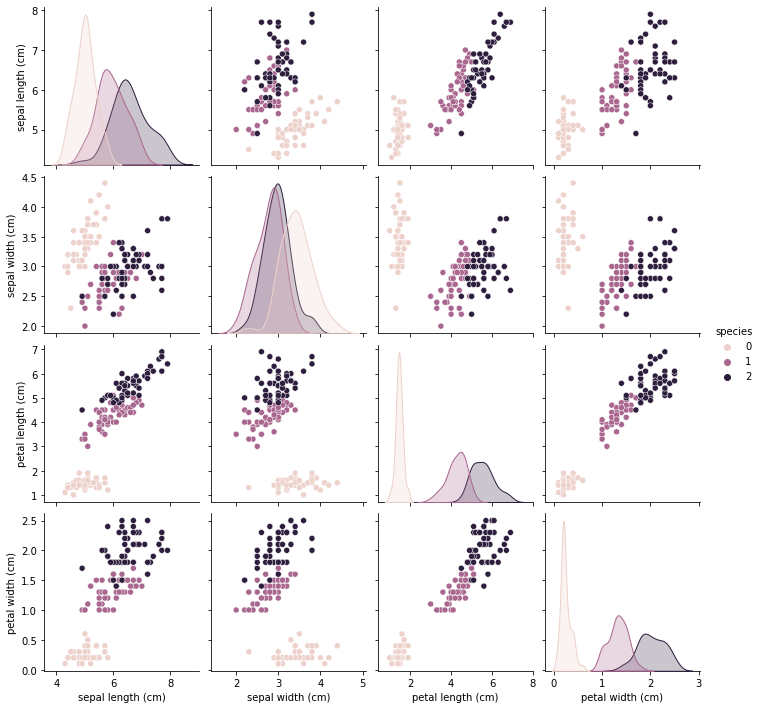

In [ ]:
sns.pairplot(data, hue='species')
plt.show()

In [ ]:
dataset=data.values
X=dataset[:, 0:4].astype(float)
Y=dataset[:,4]

In [ ]:
from keras.utils import np_utils

Y_encoded=np_utils.to_categorical(Y) # 활성화 함수를 적용시켜주기 위해 0~1값으로 변환

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model=Sequential()
model.add(Dense(16, input_dim=4, activation='relu'))
model.add(Dense(3, activation='softmax'))

- softmax는 총합이 1인 형태로 바꿔서 계산해주는 함수입니다. 합계가 1인 형태로 변환하면 큰 값이 두드러지게 나타나고 작은 값은 더 작아집니다.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X, Y_encoded, epochs=50, batch_size=5)

Epoch 1/50
30/30 [==============================] - 11s 2ms/step - loss: 3.6180 - accuracy: 0.3159
Epoch 2/50
30/30 [==============================] - 0s 2ms/step - loss: 2.4253 - accuracy: 0.3210
Epoch 3/50
30/30 [==============================] - 0s 2ms/step - loss: 1.5642 - accuracy: 0.3551
Epoch 4/50
30/30 [==============================] - 0s 2ms/step - loss: 1.3292 - accuracy: 0.1962
Epoch 5/50
30/30 [==============================] - 0s 2ms/step - loss: 1.1145 - accuracy: 0.2385
Epoch 6/50
30/30 [==============================] - 0s 2ms/step - loss: 1.0732 - accuracy: 0.2090
Epoch 7/50
30/30 [==============================] - 0s 2ms/step - loss: 1.0572 - accuracy: 0.2132
Epoch 8/50
30/30 [==============================] - 0s 2ms/step - loss: 1.0049 - accuracy: 0.3793
Epoch 9/50
30/30 [==============================] - 0s 2ms/step - loss: 0.9500 - accuracy: 0.6312
Epoch 10/50
30/30 [==============================] - 0s 1ms/step - loss: 0.9170 - accuracy: 0.6130
Epoch 11/50
30/30 

In [ ]:
print("\n Accuracy: %.4f"%(model.evaluate(X,Y_encoded)[1]))

5/5 [==============================] - 0s 3ms/step - loss: 0.2899 - accuracy: 0.9733

 Accuracy: 0.9733


초음파 광물 예측하기
--

과적합 피하기

오차 역전파 알고리즘을 사용한 신경망의 예측 정확도는 몇 퍼센트일까? 

In [ ]:
sonar=pd.read_csv('sonar.csv')

In [ ]:
sonar=pd.DataFrame(sonar)

In [ ]:
sonar.head()

In [ ]:
sonar.columns

In [ ]:
sonar['R']

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

dataset=sonar.values

X=dataset[:, 0:60].astype(float)
Y_obj=dataset[:, 60]

# label encoder
e = LabelEncoder()
e.fit(Y_obj)
Y=e.transform(Y_obj)

In [ ]:
# 모델 설정
model=Sequential()
model.add(Dense(24, input_dim=60, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(X.shape)
print(Y.shape)

In [ ]:
history=model.fit(X,Y, epochs=200, batch_size=5)

In [ ]:
print(model.evaluate(X,Y)[1])

In [ ]:
history.history.keys()

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
acc = his_dict['accuracy']

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.set_title('train loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()


# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_loss')
ax2.set_title('train accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()


plt.show()

오버피팅 늪에서 빠져 나오기

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [ ]:
model.fit(x_train, y_train, epochs=130, batch_size=5)

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [ ]:
# 모델 학습하기
history = model.fit(x_train, y_train,
                    epochs = 130,
                    batch_size = 5,
                    validation_data = (x_val,y_val))

In [ ]:
history.history.keys()

In [ ]:

#학습결과 그려보기
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_loss')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_loss')
ax2.set_title('train and val loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()


plt.show()

모델 저장과 재사용
--

학습이 끝난 후 테스트해 본 결과가 만족스러울 대 이를 모델로 저장하여 새로운 데이터에 사용할 수 있습니다. 앞서 학습한 결과를 모델로 저장하려면 다음과 같이 실행합니다.

In [ ]:
from keras.models import load_model

model.save('my_model.h5') # 모델 저장하기

In [ ]:
del model #  테스트를 위해 메모리 내의 모델을 삭제

model=load_model('my_model.h5') #  모델 불러오기

K겹 교차검증
--

데이터셋을 여러 개로 나누어 하나씩 테스트셋으로 사용하고 나머지를 모두 합해서 학습셋으로 사용

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_fold=10
skf=StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [ ]:
accuracy=[]

for train, test in skf.split(X,Y):
    model=Sequential()
    model.add(Dense(24, input_dim=60, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1,  activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.fit(X[train],Y[train], epochs=100, batch_size=5)

    k_accuracy="%.4f"%(model.evaluate(X[test],Y[test])[1])
    accuracy.append(k_accuracy)

In [ ]:
print("\n %.f fold accuracy:" %n_fold, accuracy)

딥러닝 모델 업그레이드 하기
--

ModelCheckpoint, callback
: 각 에포크 마다 기록하기

from keras.callbacks import ModelCheckpoint

checkpoint 활용하기

from keras.callbacks import EarlyStopping : 학습의 자동중단




CNN 실행하기
--

MNIST 데이터 활용하기


In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

(x_train, y_train), (x_test, y_test)=mnist.load_data()

x_train=x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')/255
x_test=x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')/255
y_train=np_utils.to_categorical(y_train)
y_test=np_utils.to_categorical(y_test)

# 컨볼루션 신경망 설정
model=Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델 최적화 설정
MODEL_DIR='./model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10)

# 모델의 실행
history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=200, verbose=0, callbacks=[early_stopping_callback, checkpointer])

In [ ]:
print("\n Test Accuracy %.4f"%(model.evaluate(x_test, y_test)[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.0293 - accuracy: 0.9932

 Test Accuracy 0.9932


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

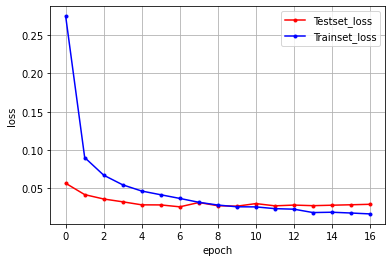

In [ ]:
# 시각화
y_vloss=history.history['val_loss']
y_loss=history.history['loss']

x_len=np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

RNN & LSTM
--

LSTM을 이용한 로이터 뉴스 카테고리 분류

In [3]:
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# seed 값 설정
seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

#불러온 데이터를 학습셋과 테스트셋으로 나누기
(x_train, y_train), (x_test, y_test)=reuters.load_data(num_words=1000, test_split=0.2)

# 데이터 확인하기
category=np.max(y_train)+1
print(category, "카테고리")
print(len(x_train), '학습용 뉴스 기사')
print(len(x_test), '테스트용 뉴스 기사')
print(x_train[0])

2121728/2110848 [==============================] - 0s 0us/step
46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


/usr/local/lib/python3.7/dist-packages/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [4]:
# 데이터 전처리
x_train=sequence.pad_sequences(x_train, maxlen=100)
x_test=sequence.pad_sequences(x_test, maxlen=100)
y_train=np_utils.to_categorical(y_train)
y_test=np_utils.to_categorical(y_test)

In [5]:
# 모델의 설정
model=Sequential()
model.add(Embedding(1000,100))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))

# 모델의 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델의 실행
history=model.fit(x_train, y_train, batch_size=100, epochs=20, validation_data=(x_test, y_test))

In [7]:
# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" %(model.evaluate(x_test, y_test)[1]))

71/71 [==============================] - 0s 6ms/step - loss: 1.1921 - accuracy: 0.7110

 Test Accuracy: 0.7110


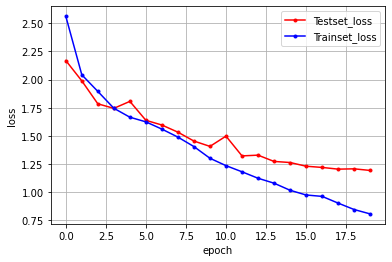

In [8]:
#  테스트셋의 오차
y_vloss=history.history['val_loss']

# 학습셋의 오차
y_loss=history.history['loss']

# 그래프로 표현
x_len=np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기
--

In [9]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM 
from keras.layers import Conv1D, MaxPool1D
from keras.datasets import imdb

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

# 학습셋과 테스트셋 지정하기
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000)

# 데이터 전처리
x_train=sequence.pad_sequences(x_train, maxlen=100)
x_test=sequence.pad_sequences(x_test, maxlen=100)

17473536/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

In [10]:
model=Sequential()
model.add(Embedding(5000,100))
model.add(Dropout(0.5))
model.add(Conv1D(64,5, padding='valid', activation='relu', strides=1))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
lstm_1 (LSTM)                (None, 55)                26400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 56        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 558,520
Trainable params: 558,520
Non-trainable params: 0
________________________________________________

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model.fit(x_train, y_train, batch_size=100, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
250/250 [==============================] - 22s 24ms/step - loss: 0.5770 - accuracy: 0.6583 - val_loss: 0.3338 - val_accuracy: 0.8555
Epoch 2/5
250/250 [==============================] - 5s 21ms/step - loss: 0.2894 - accuracy: 0.8826 - val_loss: 0.3296 - val_accuracy: 0.8592
Epoch 3/5
250/250 [==============================] - 5s 20ms/step - loss: 0.2452 - accuracy: 0.9024 - val_loss: 0.3448 - val_accuracy: 0.8540
Epoch 4/5
250/250 [==============================] - 5s 21ms/step - loss: 0.2047 - accuracy: 0.9207 - val_loss: 0.3872 - val_accuracy: 0.8527
Epoch 5/5
250/250 [==============================] - 5s 21ms/step - loss: 0.1866 - accuracy: 0.9309 - val_loss: 0.3515 - val_accuracy: 0.8569


In [13]:
# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" %(model.evaluate(x_test,y_test)[1]))

782/782 [==============================] - 5s 5ms/step - loss: 0.3515 - accuracy: 0.8569

 Test Accuracy: 0.8569


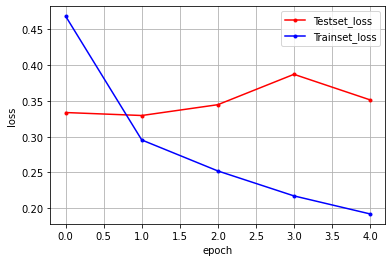

In [14]:
# 테스트셋의 오차
y_vloss=history.history['val_loss']
y_loss=history.history['loss']

# 그래프로 표현
x_len=np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label="Trainset_loss")

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc="upper right")
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()